In [1]:
# Импортируем необходимые библиотеки
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Функция для загрузки данных из нескольких листов Excel-файла
def load_data(adress, sheets):
    return pd.concat([load_data_sheet(adress, sheet) for sheet in sheets], join='outer').fillna(100)

# Функция для загрузки данных из одного листа Excel-файла
def load_data_sheet(file_adress, sheet_dt):
    sheet = pd.read_excel(file_adress, sheet_name=sheet_dt, header=3, skipfooter=2).T
    sheet.columns = sheet.iloc[0]
    sheet.drop(sheet.index[0], inplace=True)
    sheet['date'] = pd.date_range(start=sheet_dt+'-01-03', periods=len(sheet), freq='W')
    sheet.set_index('date', inplace=True)
    return sheet

In [3]:
# Класс для загрузки и хранения данных
class Data:
    def __init__(self, url):
        self.url = url
        self.data = None
        self.load_data()

    def load_data(self):
        response = requests.get(self.url)
        if response.status_code == 200:
            with open("inflation_data_new.xlsx", "wb") as file:
                file.write(response.content)
            self.data = load_data('inflation_data_new.xlsx', ['2022', '2023', '2024'])
            return "Данные успешно загружены"
        else:
            self.data = load_data('inflation_data_pre.xlsx', ['2022', '2023', '2024'])
            return "Сервер не отвечает. Использую загруженную версию данных."

In [4]:
# Создание экземпляра класса Data для загрузки данных
data_class = Data("https://rosstat.gov.ru/storage/mediabank/Nedel_ipc.xlsx")

In [5]:
# Класс для предсказаний с использованием модели ARIMA
class Predictor_ARIMA:
    def __init__(self, data_frame):
        self.data = data_frame
        self.options = data_frame.columns.to_list()
        self.selected_option = None
        self.calculation_result = None
        self.selected_image = None

    # Установка выбранной опции и вычисление результата
    def set_selected_option(self, option):
        self.selected_option = option
        self.calculate_result()
        

    # Вычисление результата модели ARIMA
    def calculate_result(self):
        data = self.data.loc[:, [self.selected_option]]
        name_of_var = data.columns[0]
        data.columns = ['data']
        data['date'] = pd.date_range(start='2022-01-01', periods=len(data), freq='W')
        data.set_index('date', inplace=True)

        # Разделение данных на обучающую и тестовую выборки
        train = data.iloc[:len(data) - 24]
        eval = data.iloc[len(data) - 24:]

        # Обучение модели ARIMA
        model = ARIMA(train, order=(2, 0, 2))
        model_fit = model.fit()

        # Валидация на тестовой выборке
        forecast_obj = model_fit.get_forecast(steps=len(eval), alpha=0.05)
        forecast = forecast_obj.predicted_mean
        conf_int = forecast_obj.conf_int()

        # Вычисление ошибок
        mae = round(mean_absolute_error(eval.values, forecast), 4)
        mse = round(mean_squared_error(eval.values, forecast), 4)
        rmse = round(np.sqrt(mse), 4)
        self.calculation_result = f"MAE на валид. выборке: {mae}\nMSE на валид. выборке: {mse}\nRMSE на валид. выборке: {rmse}\n"

        # Прогнозирование будущих значений с использованием всей выборки
        model_full = ARIMA(data, order=(2, 0, 2))
        model_full_fit = model_full.fit()
        forecast_obj_full = model_full_fit.get_forecast(steps=24, alpha=0.05)
        forecast_full = forecast_obj_full.predicted_mean
        conf_int_full = forecast_obj_full.conf_int()

        # Построение графика
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train.values, label='Training set')
        plt.plot(eval.index, eval.values, label='Validation set')
        plt.plot(eval.index, forecast, label='ARIMA predictions on validation set', color='green')
        forecast_index = pd.date_range(start=data.index[-1], periods=25, freq='W')[1:]
        plt.plot(forecast_index, forecast_full, label='Predicted values', color='blue')
        plt.fill_between(forecast_index, conf_int_full.iloc[:, 0], conf_int_full.iloc[:, 1], color='blue', alpha=0.1)
        plt.title(name_of_var)
        plt.xlabel('ARIMA(2, 0, 2) - predictions with confidence interval')
        plt.ylabel('CPI in abs. values')
        plt.legend()
        plt.grid(True)
        plt.show()

In [6]:
# Создание экземпляра класса Predictor_ARIMA для прогнозирования
my_class_instance = Predictor_ARIMA(data_class.data)

In [ ]:
# Обучаем ARIMA 2, 0, 2 на всех данных, кроме последних полугода, оцениваем точность, 
# затем обучаем на всех данных и делаем итоговое предсказание

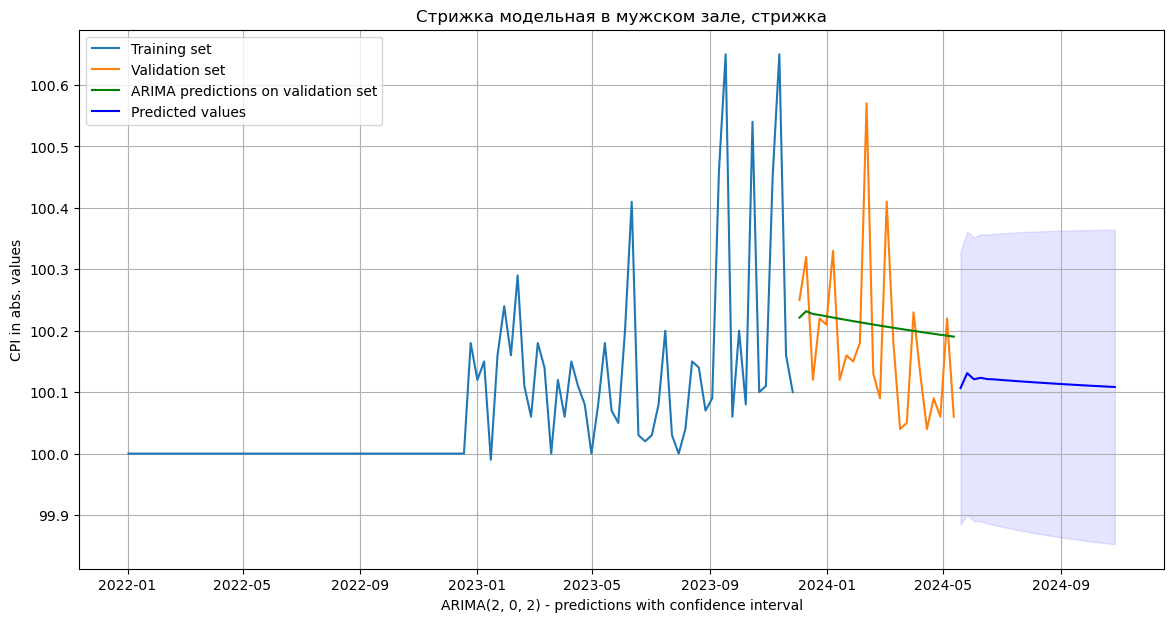

MAE на валид. выборке: 0.0983
MSE на валид. выборке: 0.0153
RMSE на валид. выборке: 0.1237



In [7]:
# Установить опцию и вычислить результат
option = my_class_instance.options[114]  # Например, выбираем первую опцию; от 0 до 114
my_class_instance.set_selected_option(option)
print(my_class_instance.calculation_result)